<a href="https://colab.research.google.com/github/anirudh-g/Msc-Data-science/blob/master/Chart_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SETUP

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import random
random.seed(10)
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#7 classes: Area chart, Bar chart, Line Chart, pie chart, scatter plot. 100 images per class. 80/20 train/val split
train_dir = '/content/drive/My Drive/Colab Notebooks/charts/Train'
validation_dir = '/content/drive/My Drive/Colab Notebooks/charts/Validation'
test_dir = '/content/drive/My Drive/Colab Notebooks/charts/Test'

#DATA PROCESSING

In [ ]:
#List of all basic tunable parameters of the model - to be updated
img_width, img_height = 224, 224
nb_train_samples = 560
nb_validation_samples = 140
epochs = 50
batch_size = 16

In [ ]:
#checking whether the rgb channel is first or last to feed the input shape accordingly
if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

In [ ]:
def noisy_generator(batches):
    for batch_x, batch_y in batches:
        sigma = np.random.exponential(0.15)
        noise = np.random.normal(scale=sigma, size=batch_x.shape)
        batch_noisy = np.clip(batch_x + noise, 0, 1)
        yield (batch_noisy, batch_y)

In [ ]:
#Performing augmentation on image scaling, zoom and  so that the network has more training samples
train_datagen = ImageDataGenerator( 
	rescale=1. / 255, 
	shear_range=0.2, 
	zoom_range=0.2,
	brightness_range=(0.6,0.9)) 

#Not having any augmentation apart from scaling as the validation data should resemble the real-world data as close as possible
val_datagen = ImageDataGenerator(rescale=1. / 255) 

test_datagen = ImageDataGenerator(rescale=1. /255)

train_generator = train_datagen.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical') 

validation_generator = val_datagen.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical')

test_generator = test_datagen.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical', 
	shuffle = False)

train_noisy = noisy_generator(train_generator)

Found 560 images belonging to 7 classes.
Found 140 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

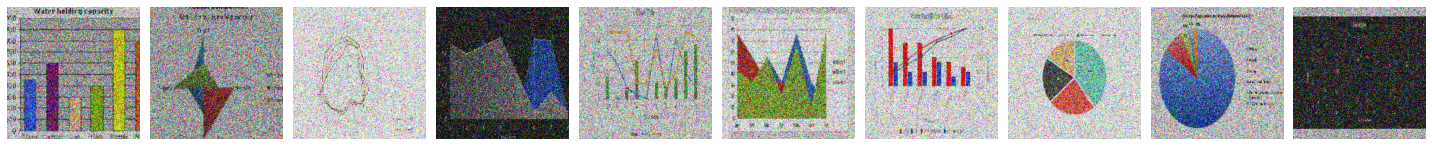

In [ ]:
sample_training_images, _ = next(train_noisy)
plotImages(sample_training_images[:10])

#TRANSFER LEARNING

# <H4> MOBILENETV2 - transfer learning

In [ ]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________

In [ ]:
base_model.trainable=False

In [ ]:
#top layer structure inspired from https://towardsdatascience.com/using-object-detection-for-complex-image-classification-scenarios-part-3-770d3fc5e3f7

top_layer = base_model.output
top_layer = GlobalAveragePooling2D()(top_layer)
top_layer = Dense(1024,activation='relu')(top_layer) #we add dense layers so that the model can learn more complex functions and classify for better results.
top_layer = Dense(1024,activation='relu')(top_layer) #dense layer 2
top_layer = Dense(512,activation='relu')(top_layer) #dense layer 3
prediction_layer = Dense(7,activation='softmax')(top_layer) #final layer with softmax activation

tl_model = keras.Model(inputs= base_model.input, outputs=prediction_layer)

In [ ]:
lr =0.001
tl_model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
len(tl_model.trainable_variables)

8

In [ ]:
tl_history = tl_model.fit( 
	train_noisy,
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 


Epoch 1/50
35/35 [==============================] - 545s 16s/step - loss: 1.2242 - accuracy: 0.5607 - val_loss: 0.3981 - val_accuracy: 0.8750
Epoch 2/50
35/35 [==============================] - 15s 428ms/step - loss: 0.6178 - accuracy: 0.7804 - val_loss: 0.3012 - val_accuracy: 0.9062
Epoch 3/50
35/35 [==============================] - 15s 418ms/step - loss: 0.5643 - accuracy: 0.7964 - val_loss: 0.2157 - val_accuracy: 0.9219
Epoch 4/50
35/35 [==============================] - 15s 421ms/step - loss: 0.4970 - accuracy: 0.8429 - val_loss: 0.2778 - val_accuracy: 0.8906
Epoch 5/50
35/35 [==============================] - 15s 420ms/step - loss: 0.5199 - accuracy: 0.8018 - val_loss: 0.4499 - val_accuracy: 0.8516
Epoch 6/50
35/35 [==============================] - 15s 418ms/step - loss: 0.4510 - accuracy: 0.8339 - val_loss: 0.2623 - val_accuracy: 0.9141
Epoch 7/50
35/35 [==============================] - 15s 420ms/step - loss: 0.3190 - accuracy: 0.8839 - val_loss: 0.2765 - val_accuracy: 0.9062


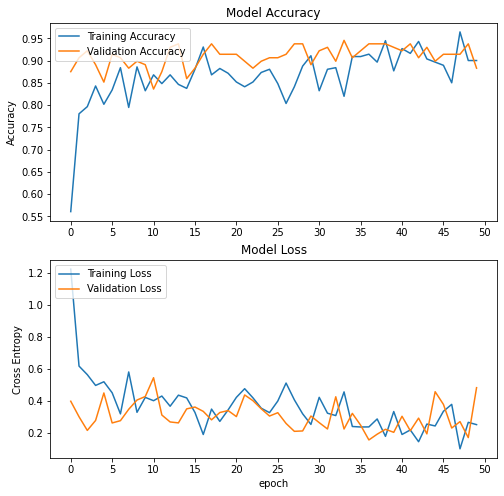

In [ ]:
#Plot based on https://www.tensorflow.org/tutorials/images/transfer_learning

acc = tl_history.history['accuracy']
val_acc = tl_history.history['val_accuracy']

loss = tl_history.history['loss']
val_loss = tl_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,55, 5))
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.xticks(np.arange(0,55, 5))
plt.title('Model Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [ ]:
tl_model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr/10),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
len(tl_model.trainable_variables)

64

In [ ]:
fine_tune_epochs = 50
total_epochs =  50 + fine_tune_epochs

tl_history_fine = tl_model.fit( 
	train_noisy, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=total_epochs,
  initial_epoch= tl_history.epoch[-1], 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 

Epoch 50/100
35/35 [==============================] - 18s 524ms/step - loss: 0.7794 - accuracy: 0.7750 - val_loss: 1.0358 - val_accuracy: 0.8359
Epoch 51/100
35/35 [==============================] - 18s 506ms/step - loss: 0.4881 - accuracy: 0.8589 - val_loss: 0.8053 - val_accuracy: 0.8750
Epoch 52/100
35/35 [==============================] - 17s 498ms/step - loss: 0.4632 - accuracy: 0.8571 - val_loss: 1.1718 - val_accuracy: 0.8125
Epoch 53/100
35/35 [==============================] - 18s 506ms/step - loss: 0.3010 - accuracy: 0.8982 - val_loss: 1.2630 - val_accuracy: 0.8047
Epoch 54/100
35/35 [==============================] - 18s 503ms/step - loss: 0.2052 - accuracy: 0.9321 - val_loss: 1.2419 - val_accuracy: 0.8047
Epoch 55/100
35/35 [==============================] - 18s 506ms/step - loss: 0.2197 - accuracy: 0.9321 - val_loss: 1.4745 - val_accuracy: 0.7891
Epoch 56/100
35/35 [==============================] - 17s 497ms/step - loss: 0.3134 - accuracy: 0.8964 - val_loss: 1.0585 - val_ac

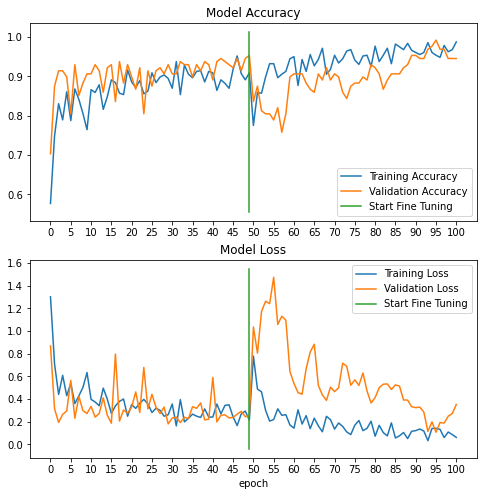

In [ ]:
acc += tl_history_fine.history['accuracy']
val_acc += tl_history_fine.history['val_accuracy']
loss += tl_history_fine.history['loss']
val_loss += tl_history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xticks(np.arange(0,105, 5))
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xticks(np.arange(0,105, 5))
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.xlabel('epoch')
plt.show()

# <H4>VGG16 - transfer learning

In [ ]:
vgg_base = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
vgg_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
vgg_base.trainable=False

In [ ]:
vgg_top_layer = vgg_base.output
vgg_top_layer = GlobalAveragePooling2D()(vgg_top_layer)
vgg_top_layer = Dense(1024,activation='relu')(vgg_top_layer) #we add dense layers so that the model can learn more complex functions and classify for better results.
vgg_top_layer = Dense(1024,activation='relu')(vgg_top_layer) #dense layer 2
vgg_top_layer = Dense(512,activation='relu')(vgg_top_layer) #dense layer 3
vgg_prediction_layer = Dense(7,activation='softmax')(vgg_top_layer) #final layer with softmax activation

vgg_tl = keras.Model(inputs= vgg_base.input, outputs=vgg_prediction_layer)

In [ ]:
lr=0.001
vgg_tl.compile(optimizer=tf.optimizers.Adam(learning_rate=lr),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy']) 

In [ ]:
len(vgg_tl.trainable_variables)

8

In [ ]:
vgg_history = vgg_tl.fit( 
	train_noisy, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
35/35 [==============================] - 18s 506ms/step - loss: 1.3390 - accuracy: 0.4982 - val_loss: 0.6710 - val_accuracy: 0.7734
Epoch 2/50
35/35 [==============================] - 18s 515ms/step - loss: 0.7540 - accuracy: 0.7143 - val_loss: 0.3771 - val_accuracy: 0.8828
Epoch 3/50
35/35 [==============================] - 18s 515ms/step - loss: 0.6251 - accuracy: 0.7625 - val_loss: 0.3718 - val_accuracy: 0.8594
Epoch 4/50
35/35 [==============================] - 18s 515ms/step - loss: 0.4110 - accuracy: 0.8500 - val_loss: 0.4802 - val_accuracy: 0.8438
Epoch 5/50
35/35 [==============================] - 18s 509ms/step - loss: 0.4640 - accuracy: 0.8429 - val_loss: 0.3118 - val_accuracy: 0.9062
Epoch 6/50
35/35 [==============================] - 18s 514ms/step - loss: 0.3721 - accuracy: 0.8696 - val_loss: 0.4531 - val_accuracy: 0.8359
Epoch 7/50
35/35 [==============================] - 18s 506ms/step - loss: 0.3068 - accuracy: 0.8750 - val_loss: 0.3371 - val_accuracy: 0.9062

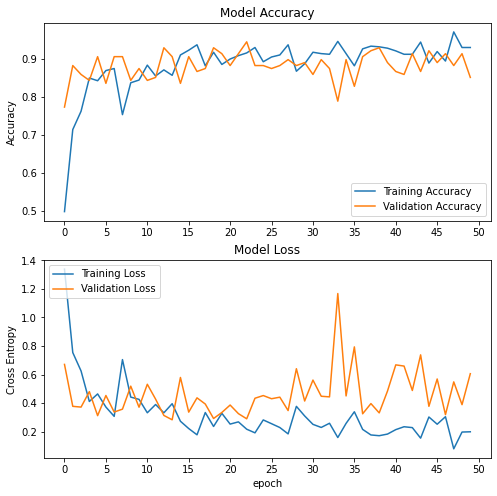

In [ ]:
vgg_acc = vgg_history.history['accuracy']
vgg_val_acc = vgg_history.history['val_accuracy']

vgg_loss = vgg_history.history['loss']
vgg_val_loss = vgg_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(vgg_acc, label='Training Accuracy')
plt.plot(vgg_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,55, 5))
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(vgg_loss, label='Training Loss')
plt.plot(vgg_val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.xticks(np.arange(0,55, 5))
plt.title('Model Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
vgg_base.trainable = True

print("Number of layers in the base model: ", len(vgg_base.layers))

fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg_base.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  19


In [ ]:
vgg_tl.compile(optimizer=tf.optimizers.Adam(learning_rate=lr/10),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
len(vgg_tl.trainable_variables)

14

In [ ]:
fine_tune_epochs = 50
total_epochs =  epochs + fine_tune_epochs

vgg_history_fine = vgg_tl.fit( 
	train_noisy, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=total_epochs,
  initial_epoch= vgg_history.epoch[-1], 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 

Epoch 50/100
35/35 [==============================] - 18s 522ms/step - loss: 0.7177 - accuracy: 0.7911 - val_loss: 0.4209 - val_accuracy: 0.9141
Epoch 51/100
35/35 [==============================] - 18s 522ms/step - loss: 0.3887 - accuracy: 0.9036 - val_loss: 0.3515 - val_accuracy: 0.9062
Epoch 52/100
35/35 [==============================] - 18s 521ms/step - loss: 0.3495 - accuracy: 0.8875 - val_loss: 0.3489 - val_accuracy: 0.9062
Epoch 53/100
35/35 [==============================] - 18s 509ms/step - loss: 0.2298 - accuracy: 0.9214 - val_loss: 0.3598 - val_accuracy: 0.9375
Epoch 54/100
35/35 [==============================] - 18s 517ms/step - loss: 0.2259 - accuracy: 0.9125 - val_loss: 0.6567 - val_accuracy: 0.8984
Epoch 55/100
35/35 [==============================] - 18s 518ms/step - loss: 0.3111 - accuracy: 0.8946 - val_loss: 0.5293 - val_accuracy: 0.8984
Epoch 56/100
35/35 [==============================] - 18s 513ms/step - loss: 0.3228 - accuracy: 0.8929 - val_loss: 0.2597 - val_ac

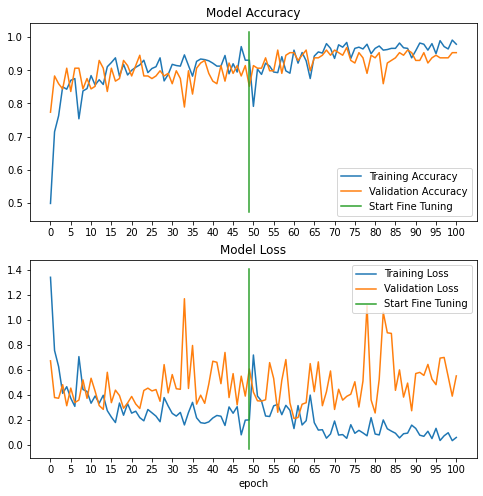

In [ ]:
vgg_acc += vgg_history_fine.history['accuracy']
vgg_val_acc += vgg_history_fine.history['val_accuracy']
vgg_loss += vgg_history_fine.history['loss']
vgg_val_loss += vgg_history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(vgg_acc, label='Training Accuracy')
plt.plot(vgg_val_acc, label='Validation Accuracy')
plt.xticks(np.arange(0,105, 5))
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(vgg_loss, label='Training Loss')
plt.plot(vgg_val_loss, label='Validation Loss')
plt.xticks(np.arange(0,105, 5))
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.xlabel('epoch')
plt.show()

VGG16 - optimized

In [ ]:
vgg_base_opt = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
vgg_base_opt.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
vgg_base_opt.trainable=False

In [ ]:
vgg_top_layer_opt = vgg_base_opt.output
vgg_top_layer_opt = GlobalAveragePooling2D()(vgg_top_layer_opt)
vgg_top_layer_opt = Dense(1024,activation='relu')(vgg_top_layer_opt) #we add dense layers so that the model can learn more complex functions and classify for better results.
vgg_prediction_layer_opt = Dense(7,activation='softmax')(vgg_top_layer_opt) #final layer with softmax activation

vgg_tl_opt = keras.Model(inputs= vgg_base_opt.input, outputs=vgg_prediction_layer_opt)

In [ ]:
lr=0.001
vgg_tl_opt.compile(optimizer=tf.optimizers.Adam(learning_rate=lr),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy']) 

In [ ]:
len(vgg_tl_opt.trainable_variables)

4

In [ ]:
vgg_history_opt = vgg_tl_opt.fit( 
	train_noisy, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
35/35 [==============================] - 759s 22s/step - loss: 1.3919 - accuracy: 0.5321 - val_loss: 0.8146 - val_accuracy: 0.8438
Epoch 2/50
35/35 [==============================] - 15s 427ms/step - loss: 0.7302 - accuracy: 0.7946 - val_loss: 0.4484 - val_accuracy: 0.9297
Epoch 3/50
35/35 [==============================] - 15s 432ms/step - loss: 0.6304 - accuracy: 0.7964 - val_loss: 0.3927 - val_accuracy: 0.9062
Epoch 4/50
35/35 [==============================] - 15s 426ms/step - loss: 0.3980 - accuracy: 0.8732 - val_loss: 0.3923 - val_accuracy: 0.8672
Epoch 5/50
35/35 [==============================] - 15s 427ms/step - loss: 0.4320 - accuracy: 0.8446 - val_loss: 0.2533 - val_accuracy: 0.9297
Epoch 6/50
35/35 [==============================] - 15s 426ms/step - loss: 0.4255 - accuracy: 0.8625 - val_loss: 0.2313 - val_accuracy: 0.9375
Epoch 7/50
35/35 [==============================] - 15s 429ms/step - loss: 0.3839 - accuracy: 0.8732 - val_loss: 0.2385 - val_accuracy: 0.9375


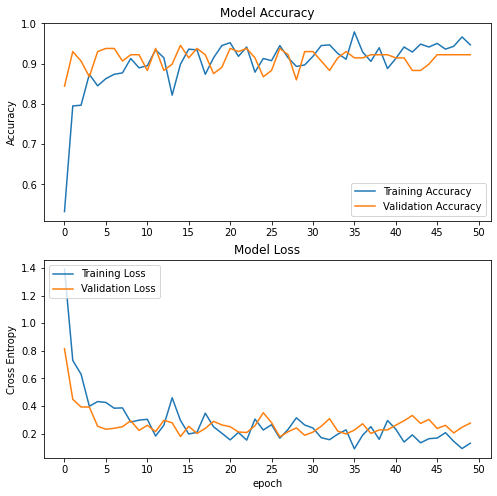

In [ ]:
vgg_acc_opt = vgg_history_opt.history['accuracy']
vgg_val_acc_opt = vgg_history_opt.history['val_accuracy']

vgg_loss_opt = vgg_history_opt.history['loss']
vgg_val_loss_opt = vgg_history_opt.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(vgg_acc_opt, label='Training Accuracy')
plt.plot(vgg_val_acc_opt, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,55, 5))
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(vgg_loss_opt, label='Training Loss')
plt.plot(vgg_val_loss_opt, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.xticks(np.arange(0,55, 5))
plt.title('Model Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
vgg_base_opt.trainable = True

print("Number of layers in the base model: ", len(vgg_base_opt.layers))

fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg_base_opt.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  19


In [ ]:
vgg_tl_opt.compile(optimizer=tf.optimizers.Adam(learning_rate=lr/10),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
len(vgg_tl_opt.trainable_variables)

10

In [ ]:
fine_tune_epochs = 50
total_epochs =  epochs + fine_tune_epochs

vgg_history_fine_opt = vgg_tl_opt.fit( 
	train_noisy, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=total_epochs,
  initial_epoch= vgg_history_opt.epoch[-1], 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 

Epoch 50/100
35/35 [==============================] - 15s 430ms/step - loss: 0.7014 - accuracy: 0.7821 - val_loss: 0.2853 - val_accuracy: 0.8906
Epoch 51/100
35/35 [==============================] - 15s 429ms/step - loss: 0.3899 - accuracy: 0.8607 - val_loss: 0.2731 - val_accuracy: 0.9141
Epoch 52/100
35/35 [==============================] - 15s 425ms/step - loss: 0.1789 - accuracy: 0.9411 - val_loss: 0.0824 - val_accuracy: 0.9688
Epoch 53/100
35/35 [==============================] - 15s 431ms/step - loss: 0.3736 - accuracy: 0.8857 - val_loss: 0.2152 - val_accuracy: 0.9531
Epoch 54/100
35/35 [==============================] - 15s 428ms/step - loss: 0.2867 - accuracy: 0.9125 - val_loss: 0.4765 - val_accuracy: 0.9219
Epoch 55/100
35/35 [==============================] - 15s 427ms/step - loss: 0.1444 - accuracy: 0.9482 - val_loss: 0.7889 - val_accuracy: 0.9141
Epoch 56/100
35/35 [==============================] - 15s 429ms/step - loss: 0.1604 - accuracy: 0.9446 - val_loss: 0.3440 - val_ac

In [ ]:
vgg_tl_opt.save('/content/drive/My Drive/Colab Notebooks/Transfer learning model', save_format = 'tf')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Transfer learning model/assets


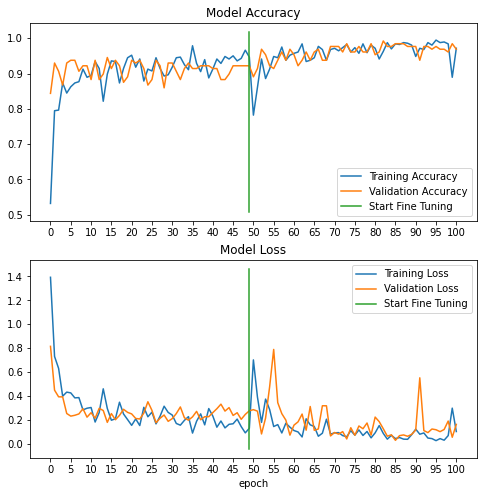

In [ ]:
vgg_acc_opt += vgg_history_fine_opt.history['accuracy']
vgg_val_acc_opt += vgg_history_fine_opt.history['val_accuracy']
vgg_loss_opt += vgg_history_fine_opt.history['loss']
vgg_val_loss_opt += vgg_history_fine_opt.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(vgg_acc_opt, label='Training Accuracy')
plt.plot(vgg_val_acc_opt, label='Validation Accuracy')
plt.xticks(np.arange(0,105, 5))
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(vgg_loss_opt, label='Training Loss')
plt.plot(vgg_val_loss_opt, label='Validation Loss')
plt.xticks(np.arange(0,105, 5))
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
load = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Transfer learning model')

In [ ]:
#Confusion matrix plotting function taken from https://sites.google.com/view/amarnath-r/keras-deep-learning-image-classification-a-simple-example
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

np.set_printoptions(precision=2)

Normalized confusion matrix
[[0.9  0.   0.05 0.   0.   0.05 0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.05 0.   0.9  0.   0.   0.05]
 [0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.05 0.   0.   0.   0.95]]


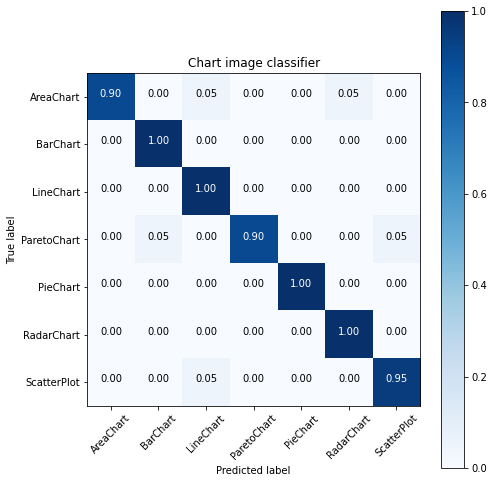

In [ ]:
y_pred_1 = load.predict(test_generator)
y_prediction_1 = np.argmax(y_pred_1 , axis=1)
conf_matrix_1=confusion_matrix(test_generator.classes, y_prediction_1)
target_names = ['AreaChart', 'BarChart', 'LineChart', 'ParetoChart', 'PieChart', 'RadarChart', 'ScatterPlot']
final_confusion_matrix_1 = plt.figure(figsize=(7, 7))
plot_confusion_matrix(conf_matrix_1, classes=target_names, normalize=True, title='Chart image classifier')

In [ ]:
print(classification_report(test_generator.classes, y_prediction_1, target_names=target_names))

              precision    recall  f1-score   support

   AreaChart       1.00      0.90      0.95        20
    BarChart       0.95      1.00      0.98        20
   LineChart       0.91      1.00      0.95        20
 ParetoChart       1.00      0.90      0.95        20
    PieChart       1.00      1.00      1.00        20
  RadarChart       0.95      1.00      0.98        20
 ScatterPlot       0.95      0.95      0.95        20

    accuracy                           0.96       140
   macro avg       0.97      0.96      0.96       140
weighted avg       0.97      0.96      0.96       140



[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 140 samples in 0.000s...
[t-SNE] Computed neighbors for 140 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 140 / 140
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.409904
[t-SNE] KL divergence after 1000 iterations: 0.391869


Text(0.5, 1.0, 't-SNE Visualisation')

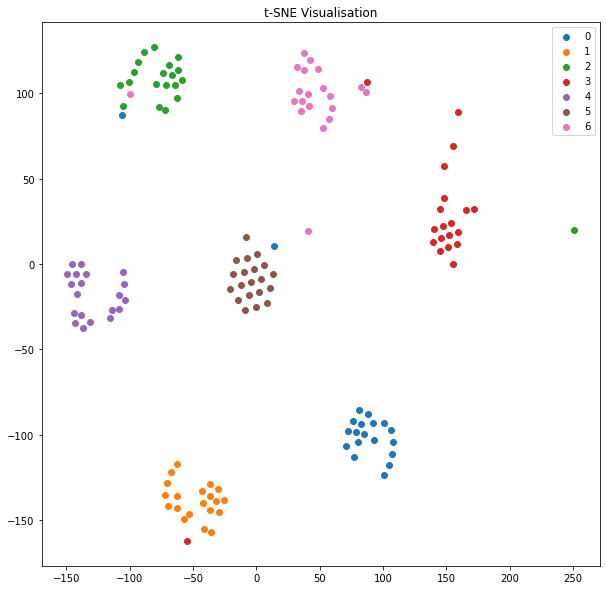

In [ ]:
# Reduce to 7 dimensions with PCA
pca = PCA(n_components=7)
pca_results = pca.fit_transform(y_pred_1)
#print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

# Apply t-SNE on the PCA results to reduce to 2D
tsne = TSNE(n_components=2, perplexity=8, learning_rate=300, verbose = 1)
tsne_results = tsne.fit_transform(pca_results[:140])

# Convert to binary class matrix
categoricalClasses = np_utils.to_categorical(test_generator.classes[:140], num_classes = 7)

#Plot the points in 2D
colour_map = np.argmax(categoricalClasses, axis=1)
tsneFigure = plt.figure(figsize=(10,10))
for colour in range(0,7):
    indices = np.where(colour_map==colour)
    indices = indices[0]
    plt.scatter(tsne_results[indices,0],
                tsne_results[indices,1],
                label=colour)
plt.legend()
plt.title('t-SNE Visualisation')

ABLATION STUDY

remove data aug and noise

In [ ]:
train_datagen_2 = ImageDataGenerator(rescale=1. / 255)

val_datagen_2 = ImageDataGenerator(rescale=1. / 255) 

test_datagen_2 = ImageDataGenerator(rescale=1. /255)

train_generator_2 = train_datagen_2.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical')

validation_generator_2 = val_datagen_2.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical')

test_generator_2 = test_datagen_2.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical', 
  shuffle=False)

Found 560 images belonging to 7 classes.
Found 140 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


In [ ]:
vgg_base2 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
vgg_base2.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
vgg_base2.trainable=False

In [ ]:
vgg_top_layer2 = vgg_base2.output
vgg_top_layer2 = GlobalAveragePooling2D()(vgg_top_layer2)
vgg_top_layer2 = Dense(1024,activation='relu')(vgg_top_layer2) #we add dense layers so that the model can learn more complex functions and classify for better results.
#vgg_top_layer_opt = Dense(512,activation='relu')(vgg_top_layer_opt) #dense layer 3
vgg_prediction_layer2 = Dense(7,activation='softmax')(vgg_top_layer2) #final layer with softmax activation

vgg_tl2 = keras.Model(inputs= vgg_base2.input, outputs=vgg_prediction_layer2)

In [ ]:
lr=0.001
vgg_tl2.compile(optimizer=tf.optimizers.Adam(learning_rate=lr),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy']) 

In [ ]:
vgg_history2 = vgg_tl2.fit( 
	train_generator_2, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=50, 
	validation_data=validation_generator_2, 
	validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
35/35 [==============================] - 309s 9s/step - loss: 1.2546 - accuracy: 0.6071 - val_loss: 0.6682 - val_accuracy: 0.8516
Epoch 2/50
35/35 [==============================] - 6s 160ms/step - loss: 0.4205 - accuracy: 0.9339 - val_loss: 0.3485 - val_accuracy: 0.9375
Epoch 3/50
35/35 [==============================] - 6s 160ms/step - loss: 0.2466 - accuracy: 0.9554 - val_loss: 0.2464 - val_accuracy: 0.9609
Epoch 4/50
35/35 [==============================] - 6s 160ms/step - loss: 0.1588 - accuracy: 0.9714 - val_loss: 0.2208 - val_accuracy: 0.9453
Epoch 5/50
35/35 [==============================] - 6s 159ms/step - loss: 0.1269 - accuracy: 0.9786 - val_loss: 0.1997 - val_accuracy: 0.9531
Epoch 6/50
35/35 [==============================] - 6s 159ms/step - loss: 0.0978 - accuracy: 0.9804 - val_loss: 0.1692 - val_accuracy: 0.9297
Epoch 7/50
35/35 [==============================] - 6s 160ms/step - loss: 0.0983 - accuracy: 0.9786 - val_loss: 0.1694 - val_accuracy: 0.9453
Epoch 8

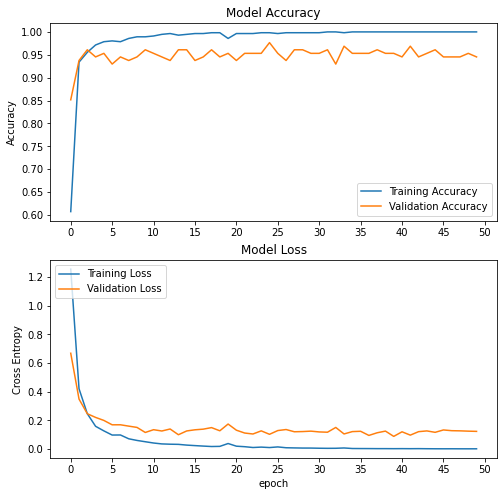

In [ ]:
vgg_acc2 = vgg_history2.history['accuracy']
vgg_val_acc2 = vgg_history2.history['val_accuracy']

vgg_loss2 = vgg_history2.history['loss']
vgg_val_loss2 = vgg_history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(vgg_acc2, label='Training Accuracy')
plt.plot(vgg_val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,55, 5))
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(vgg_loss2, label='Training Loss')
plt.plot(vgg_val_loss2, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.xticks(np.arange(0,55, 5))
plt.title('Model Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
vgg_base2.trainable = True

print("Number of layers in the base model: ", len(vgg_base2.layers))

fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg_base2.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  19


In [ ]:
vgg_tl2.compile(optimizer=tf.optimizers.Adam(learning_rate=lr/10),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 50
total_epochs =  epochs + fine_tune_epochs

vgg_history2_fine = vgg_tl2.fit( 
	train_generator_2, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=total_epochs,
  initial_epoch= vgg_history2.epoch[-1], 
	validation_data=validation_generator_2, 
	validation_steps=nb_validation_samples // batch_size)

Epoch 50/100
35/35 [==============================] - 6s 173ms/step - loss: 0.2858 - accuracy: 0.9429 - val_loss: 0.1119 - val_accuracy: 0.9531
Epoch 51/100
35/35 [==============================] - 6s 165ms/step - loss: 0.0793 - accuracy: 0.9679 - val_loss: 0.3522 - val_accuracy: 0.9062
Epoch 52/100
35/35 [==============================] - 6s 167ms/step - loss: 0.0351 - accuracy: 0.9911 - val_loss: 0.0830 - val_accuracy: 0.9766
Epoch 53/100
35/35 [==============================] - 6s 167ms/step - loss: 0.0311 - accuracy: 0.9911 - val_loss: 0.1641 - val_accuracy: 0.9609
Epoch 54/100
35/35 [==============================] - 6s 167ms/step - loss: 0.0090 - accuracy: 0.9946 - val_loss: 0.1205 - val_accuracy: 0.9766
Epoch 55/100
35/35 [==============================] - 6s 167ms/step - loss: 7.7269e-04 - accuracy: 1.0000 - val_loss: 0.0781 - val_accuracy: 0.9844
Epoch 56/100
35/35 [==============================] - 6s 164ms/step - loss: 8.2388e-05 - accuracy: 1.0000 - val_loss: 0.1398 - val_a

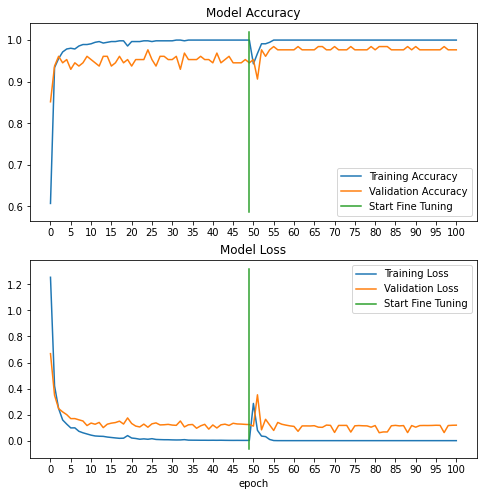

In [ ]:
vgg_acc2 += vgg_history2_fine.history['accuracy']
vgg_val_acc2 += vgg_history2_fine.history['val_accuracy']
vgg_loss2 += vgg_history2_fine.history['loss']
vgg_val_loss2 += vgg_history2_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(vgg_acc2, label='Training Accuracy')
plt.plot(vgg_val_acc2, label='Validation Accuracy')
plt.xticks(np.arange(0,105, 5))
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(vgg_loss2, label='Training Loss')
plt.plot(vgg_val_loss2, label='Validation Loss')
plt.xticks(np.arange(0,105, 5))
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.xlabel('epoch')
plt.show()

Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.95 0.   0.   0.   0.05]
 [0.05 0.   0.   0.9  0.   0.   0.05]
 [0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.  ]]


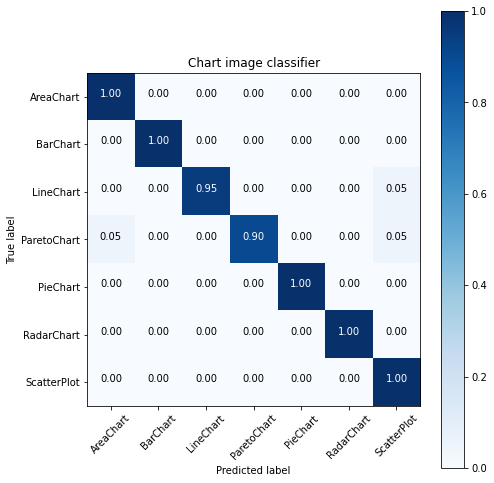

In [ ]:
y_pred_2 = vgg_tl2.predict(test_generator)
y_prediction_2 = np.argmax(y_pred_2 , axis=1)
conf_matrix_2=confusion_matrix(test_generator_2.classes, y_prediction_2)
target_names = ['AreaChart', 'BarChart', 'LineChart', 'ParetoChart', 'PieChart', 'RadarChart', 'ScatterPlot']
final_confusion_matrix_2 = plt.figure(figsize=(7, 7))
plot_confusion_matrix(conf_matrix_2, classes=target_names, normalize=True, title='Chart image classifier')

 remove gaussian noise

In [ ]:
vgg_base3 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
vgg_base3.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
vgg_base3.trainable=False

In [ ]:
vgg_top_layer3 = vgg_base3.output
vgg_top_layer3 = GlobalAveragePooling2D()(vgg_top_layer3)
vgg_top_layer3 = Dense(1024,activation='relu')(vgg_top_layer3) #we add dense layers so that the model can learn more complex functions and classify for better results.
vgg_prediction_layer3 = Dense(7,activation='softmax')(vgg_top_layer3) #final layer with softmax activation

vgg_tl3 = keras.Model(inputs= vgg_base3.input, outputs=vgg_prediction_layer3)

In [ ]:
lr=0.001
vgg_tl3.compile(optimizer=tf.optimizers.Adam(learning_rate=lr),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy']) 

In [ ]:
vgg_history3 = vgg_tl3.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=50, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
35/35 [==============================] - 13s 361ms/step - loss: 1.2042 - accuracy: 0.6696 - val_loss: 0.6169 - val_accuracy: 0.8594
Epoch 2/50
35/35 [==============================] - 12s 351ms/step - loss: 0.4612 - accuracy: 0.9107 - val_loss: 0.3359 - val_accuracy: 0.8906
Epoch 3/50
35/35 [==============================] - 12s 350ms/step - loss: 0.2938 - accuracy: 0.9393 - val_loss: 0.2277 - val_accuracy: 0.9375
Epoch 4/50
35/35 [==============================] - 13s 358ms/step - loss: 0.2126 - accuracy: 0.9518 - val_loss: 0.2367 - val_accuracy: 0.9375
Epoch 5/50
35/35 [==============================] - 12s 353ms/step - loss: 0.1872 - accuracy: 0.9482 - val_loss: 0.2004 - val_accuracy: 0.9531
Epoch 6/50
35/35 [==============================] - 12s 352ms/step - loss: 0.1654 - accuracy: 0.9536 - val_loss: 0.1568 - val_accuracy: 0.9609
Epoch 7/50
35/35 [==============================] - 12s 352ms/step - loss: 0.1044 - accuracy: 0.9732 - val_loss: 0.1621 - val_accuracy: 0.9297

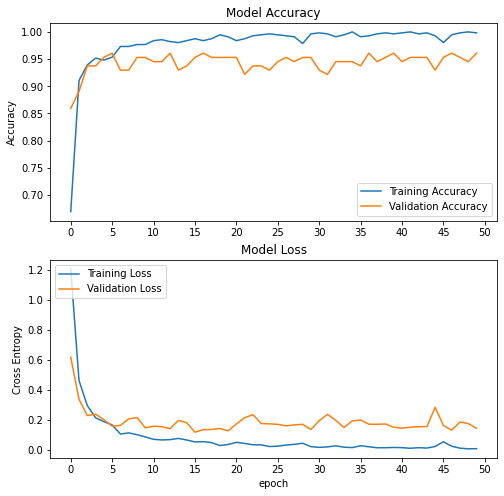

In [ ]:
vgg_acc3 = vgg_history3.history['accuracy']
vgg_val_acc3 = vgg_history3.history['val_accuracy']

vgg_loss3 = vgg_history3.history['loss']
vgg_val_loss3 = vgg_history3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(vgg_acc3, label='Training Accuracy')
plt.plot(vgg_val_acc3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,55, 5))
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(vgg_loss3, label='Training Loss')
plt.plot(vgg_val_loss3, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.xticks(np.arange(0,55, 5))
plt.title('Model Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
vgg_base3.trainable = True

print("Number of layers in the base model: ", len(vgg_base3.layers))

fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg_base3.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  19


In [ ]:
vgg_tl3.compile(optimizer=tf.optimizers.Adam(learning_rate=lr/10),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 50
total_epochs =  epochs + fine_tune_epochs

vgg_history3_fine = vgg_tl3.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=total_epochs,
  initial_epoch= vgg_history3.epoch[-1], 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size)

Epoch 50/100
35/35 [==============================] - 13s 358ms/step - loss: 0.2760 - accuracy: 0.9411 - val_loss: 0.3066 - val_accuracy: 0.9219
Epoch 51/100
35/35 [==============================] - 12s 351ms/step - loss: 0.0715 - accuracy: 0.9786 - val_loss: 0.3982 - val_accuracy: 0.9062
Epoch 52/100
35/35 [==============================] - 12s 351ms/step - loss: 0.1038 - accuracy: 0.9714 - val_loss: 0.1381 - val_accuracy: 0.9531
Epoch 53/100
35/35 [==============================] - 12s 350ms/step - loss: 0.0112 - accuracy: 0.9982 - val_loss: 0.1503 - val_accuracy: 0.9531
Epoch 54/100
35/35 [==============================] - 12s 357ms/step - loss: 0.0097 - accuracy: 0.9982 - val_loss: 0.1286 - val_accuracy: 0.9688
Epoch 55/100
35/35 [==============================] - 12s 352ms/step - loss: 0.0043 - accuracy: 0.9964 - val_loss: 0.1562 - val_accuracy: 0.9609
Epoch 56/100
35/35 [==============================] - 12s 352ms/step - loss: 9.7117e-04 - accuracy: 1.0000 - val_loss: 0.1282 - va

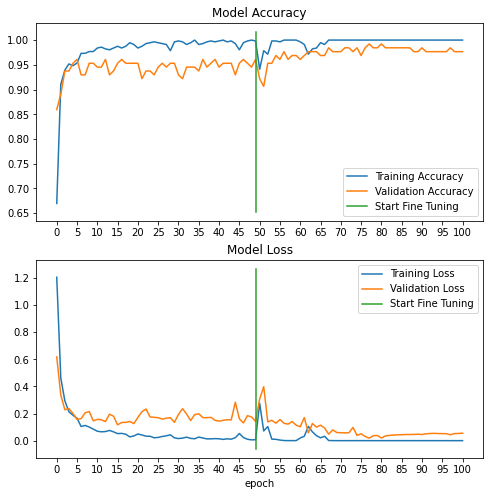

In [ ]:
vgg_acc3 += vgg_history3_fine.history['accuracy']
vgg_val_acc3 += vgg_history3_fine.history['val_accuracy']
vgg_loss3 += vgg_history3_fine.history['loss']
vgg_val_loss3 += vgg_history3_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(vgg_acc3, label='Training Accuracy')
plt.plot(vgg_val_acc3, label='Validation Accuracy')
plt.xticks(np.arange(0,105, 5))
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(vgg_loss3, label='Training Loss')
plt.plot(vgg_val_loss3, label='Validation Loss')
plt.xticks(np.arange(0,105, 5))
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.xlabel('epoch')
plt.show()

Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.05 0.05 0.9  0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.05 0.   0.   0.95 0.  ]
 [0.   0.   0.   0.   0.   0.   1.  ]]


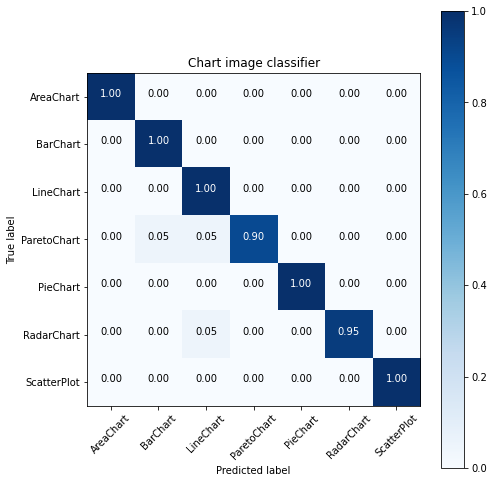

In [ ]:
y_pred_3 = vgg_tl3.predict(test_generator)
y_prediction_3 = np.argmax(y_pred_3 , axis=1)
conf_matrix_3=confusion_matrix(test_generator.classes, y_prediction_3)
target_names = ['AreaChart', 'BarChart', 'LineChart', 'ParetoChart', 'PieChart', 'RadarChart', 'ScatterPlot']
final_confusion_matrix_3 = plt.figure(figsize=(7, 7))
plot_confusion_matrix(conf_matrix_3, classes=target_names, normalize=True, title='Chart image classifier')